# RNN on a Time Series

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Load the dataset


In [7]:
df = pd.read_csv("S4248SM144NCEN.csv", index_col=0,parse_dates=True)

In [8]:
# Always a good idea with time series data:
df.dropna(inplace=True)
len(df)

394

In [9]:
# Always a good idea with time series data:
df.dropna(inplace=True)
len(df)

394

In [10]:
df.head()

,S4248SM144NCEN
observation_date,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [11]:
df.tail()

,S4248SM144NCEN
observation_date,
2024-06-01,16552
2024-07-01,15603
2024-08-01,16534
2024-09-01,14761
2024-10-01,16315


## Plotting time series data
We can add titles, axis labels, and other features to the plot.<br>
We're going to tighten the x-axis to fit the width of the actual data with <tt>plt.autoscale(axis='x',tight=True)</tt>.<br>
Alternatively you could set your own limits with <tt>plt.xlim(pd.Timestamp('1992-01-01'), pd.Timestamp('2019-01-01'))</tt> or some other values.

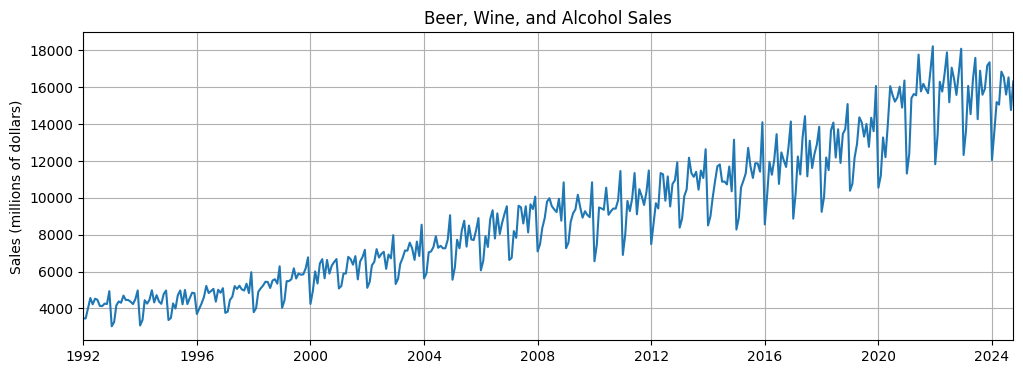

In [12]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

## Prepare the data
In the next steps we'll divide the data into train/test sets, then normalize the training values so that they fall between -1 and 1 (to improve training). We'll train the model, then predict into a period that matches the test set. Finally, we'll forecast into an unknown future.

In [13]:
# Extract values from the source .csv file
y = df['S4248SM144NCEN'].values.astype(float)

In [14]:
y

array([ 3459.,  3458.,  4002.,  4564.,  4221.,  4529.,  4466.,  4137.,
        4126.,  4259.,  4240.,  4936.,  3031.,  3261.,  4160.,  4377.,
        4307.,  4696.,  4458.,  4457.,  4364.,  4236.,  4500.,  4974.,
        3075.,  3377.,  4443.,  4261.,  4460.,  4985.,  4324.,  4719.,
        4374.,  4248.,  4784.,  4971.,  3370.,  3484.,  4269.,  3994.,
        4715.,  4974.,  4223.,  5000.,  4235.,  4554.,  4851.,  4826.,
        3699.,  3983.,  4262.,  4619.,  5219.,  4836.,  4941.,  5062.,
        4365.,  5012.,  4850.,  5097.,  3758.,  3825.,  4454.,  4635.,
        5210.,  5057.,  5231.,  5034.,  4970.,  5342.,  4831.,  5965.,
        3796.,  4019.,  4898.,  5090.,  5237.,  5447.,  5435.,  5107.,
        5515.,  5583.,  5346.,  6286.,  4032.,  4435.,  5479.,  5483.,
        5587.,  6176.,  5621.,  5889.,  5828.,  5849.,  6180.,  6771.,
        4243.,  4952.,  6008.,  5353.,  6435.,  6673.,  5636.,  6630.,
        5887.,  6322.,  6520.,  6678.,  5082.,  5216.,  5893.,  5894.,
      

In [15]:
# Define a test size
test_size = 12

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [17]:
test_set

array([17173., 17356., 12050., 13623., 15195., 15058., 16849., 16552.,
       15603., 16534., 14761., 16315.])

It's worth noting that in our previous exercise the train and test sets were tensors. Here they're numpy arrays. This is because one of the steps we're about to perform outputs an array, and we'd have to turn it into a tensor anyway.

## Normalize the data
The formula for normalizing data around zero is:<br>
### $X_{norm} = \frac{X - \mu} {\sigma}$
where $\mu$ is the population mean, and $\sigma$ is the population standard deviation.<br>
Recall that back in the CNN section we transformed image files using <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize'><tt><strong>torchvision.transforms.Normalize(<em>mean, std</em>)</strong></tt></a>, both because it was built into DataLoader, and because our pretrained models expected specific normalization values.<br>

Ultimately we want to perform <a href='https://en.wikipedia.org/wiki/Feature_scaling'>min/max feature scaling</a> so that our values fall between -1 and 1, as this makes hyperparameters converge faster.<br>The formula for this would be:<br>
### $X^{\prime} = a + \frac{(X - X_{min}) (b - a)} {X_{max} - X_{min}}$
where $a={-1}$ and $b=1$<br>

We can use scikit-learn to do this, with <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html'><tt><strong>sklearn.preprocessing.MinMaxScaler()</strong></tt></a>

NOTE: We only want to normalize the training set to avoid data leakage. If we include the test set then the higher average values of the test set could become part of the signal in the training set. There's a good article on data leakage <a href='test_set = input_data(test_norm,window_size)'>here</a>.

After using transformed data to train the model and generate predictions, we'll inverse_transform the predicted values so that we can compare them to the actual test data.

In [18]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [20]:
scaler.fit_transform(train_set.reshape(-1, 1))

array([[-0.94365085],
       [-0.9437825 ],
       [-0.87216115],
       [-0.79816997],
       [-0.84332829],
       [-0.80277796],
       [-0.81107235],
       [-0.85438747],
       [-0.85583569],
       [-0.83832532],
       [-0.84082681],
       [-0.7491936 ],
       [-1.        ],
       [-0.96971891],
       [-0.85135936],
       [-0.82278981],
       [-0.83200579],
       [-0.78079126],
       [-0.8121256 ],
       [-0.81225726],
       [-0.82450135],
       [-0.84135343],
       [-0.80659601],
       [-0.74419064],
       [-0.9942071 ],
       [-0.95444671],
       [-0.81410045],
       [-0.83806201],
       [-0.81186229],
       [-0.74274241],
       [-0.82976763],
       [-0.77776315],
       [-0.82318478],
       [-0.83977355],
       [-0.76920545],
       [-0.74458561],
       [-0.95536831],
       [-0.94035942],
       [-0.83700876],
       [-0.8732144 ],
       [-0.77828978],
       [-0.74419064],
       [-0.84306497],
       [-0.74076756],
       [-0.84148509],
       [-0

In [19]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [21]:
train_norm

array([[-0.94365085],
       [-0.9437825 ],
       [-0.87216115],
       [-0.79816997],
       [-0.84332829],
       [-0.80277796],
       [-0.81107235],
       [-0.85438747],
       [-0.85583569],
       [-0.83832532],
       [-0.84082681],
       [-0.7491936 ],
       [-1.        ],
       [-0.96971891],
       [-0.85135936],
       [-0.82278981],
       [-0.83200579],
       [-0.78079126],
       [-0.8121256 ],
       [-0.81225726],
       [-0.82450135],
       [-0.84135343],
       [-0.80659601],
       [-0.74419064],
       [-0.9942071 ],
       [-0.95444671],
       [-0.81410045],
       [-0.83806201],
       [-0.81186229],
       [-0.74274241],
       [-0.82976763],
       [-0.77776315],
       [-0.82318478],
       [-0.83977355],
       [-0.76920545],
       [-0.74458561],
       [-0.95536831],
       [-0.94035942],
       [-0.83700876],
       [-0.8732144 ],
       [-0.77828978],
       [-0.74419064],
       [-0.84306497],
       [-0.74076756],
       [-0.84148509],
       [-0

In [22]:
train_norm.min()

-1.0

In [23]:
train_norm.max()

1.0

In [24]:
train_norm.mean()

-0.22770336941720448

In [25]:
type(train_norm)

numpy.ndarray

## Prepare data for LSTM
Here we'll create our list of (seq/label) tuples from the training set. Recall that an LSTM consumes a window of samples toward the first prediction, so the size of our training set will become ((325 - test_size) - window_size).

In [26]:
len(y)

394

### Let's convert the `train_norm` from an **`array to a tensor`.**

In [27]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

In [28]:
train_norm

tensor([-0.9437, -0.9438, -0.8722, -0.7982, -0.8433, -0.8028, -0.8111, -0.8544,
        -0.8558, -0.8383, -0.8408, -0.7492, -1.0000, -0.9697, -0.8514, -0.8228,
        -0.8320, -0.7808, -0.8121, -0.8123, -0.8245, -0.8414, -0.8066, -0.7442,
        -0.9942, -0.9544, -0.8141, -0.8381, -0.8119, -0.7427, -0.8298, -0.7778,
        -0.8232, -0.8398, -0.7692, -0.7446, -0.9554, -0.9404, -0.8370, -0.8732,
        -0.7783, -0.7442, -0.8431, -0.7408, -0.8415, -0.7995, -0.7604, -0.7637,
        -0.9121, -0.8747, -0.8379, -0.7909, -0.7119, -0.7624, -0.7485, -0.7326,
        -0.8244, -0.7392, -0.7605, -0.7280, -0.9043, -0.8955, -0.8127, -0.7888,
        -0.7131, -0.7333, -0.7104, -0.7363, -0.7447, -0.6957, -0.7630, -0.6137,
        -0.8993, -0.8699, -0.7542, -0.7289, -0.7096, -0.6819, -0.6835, -0.7267,
        -0.6730, -0.6640, -0.6952, -0.5715, -0.8682, -0.8152, -0.6777, -0.6772,
        -0.6635, -0.5859, -0.6590, -0.6237, -0.6318, -0.6290, -0.5854, -0.5076,
        -0.8404, -0.7471, -0.6081, -0.69

In [29]:
# Define a window size
window_size = 12

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [30]:
# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)

370

In [31]:
# Display the first seq/label tuple in the train data
train_data[0]

(tensor([-0.9437, -0.9438, -0.8722, -0.7982, -0.8433, -0.8028, -0.8111, -0.8544,
         -0.8558, -0.8383, -0.8408, -0.7492]),
 tensor([-1.]))

## Define the model
This time we'll use an LSTM layer of size (1,100).

In [32]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

## Instantiate the model, define loss and optimization functions

In [33]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [19]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 40000
   400
   400
   100
     1
______
 41301


## Train the model

In [34]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00006531
Epoch:  2 Loss: 0.01415547
Epoch:  3 Loss: 0.00279305
Epoch:  4 Loss: 0.00703445
Epoch:  5 Loss: 0.00429417
Epoch:  6 Loss: 0.00498811
Epoch:  7 Loss: 0.00321334
Epoch:  8 Loss: 0.00287549
Epoch:  9 Loss: 0.00296601
Epoch: 10 Loss: 0.00298345
Epoch: 11 Loss: 0.00396097
Epoch: 12 Loss: 0.00513558
Epoch: 13 Loss: 0.01051615
Epoch: 14 Loss: 0.00893413
Epoch: 15 Loss: 0.01271076
Epoch: 16 Loss: 0.01126083
Epoch: 17 Loss: 0.01188425
Epoch: 18 Loss: 0.00222267
Epoch: 19 Loss: 0.00388534
Epoch: 20 Loss: 0.01261977
Epoch: 21 Loss: 0.02350096
Epoch: 22 Loss: 0.00278807
Epoch: 23 Loss: 0.00034685
Epoch: 24 Loss: 0.00002092
Epoch: 25 Loss: 0.00087463
Epoch: 26 Loss: 0.00161156
Epoch: 27 Loss: 0.00013444
Epoch: 28 Loss: 0.00017670
Epoch: 29 Loss: 0.00002998
Epoch: 30 Loss: 0.00099943
Epoch: 31 Loss: 0.00252573
Epoch: 32 Loss: 0.00084387
Epoch: 33 Loss: 0.00025312
Epoch: 34 Loss: 0.00818123
Epoch: 35 Loss: 0.00243901
Epoch: 36 Loss: 0.00537178
Epoch: 37 Loss: 0.00319549
E

## Run predictions and compare to known test set

In [35]:
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [36]:
# Display predicted values
preds[window_size:]    # equivalent to preds[-future:]

[0.7071745991706848,
 0.8963366150856018,
 0.32314401865005493,
 0.5586622357368469,
 0.6344614624977112,
 0.5666912794113159,
 0.7132613658905029,
 0.8210506439208984,
 0.578993558883667,
 0.7951469421386719,
 0.687574028968811,
 0.6049521565437317]

## Invert the normalization
We want to compare our test predictions to the original data, so we need to undo the previous normalization step. Note that <tt>inverse_transform</tt> uses the most recently applied parameters; we can rescale based on the test data, but not on the previous training data.

In [37]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[15997.844668  ],
       [17434.62475988],
       [13080.94039366],
       [14869.81901154],
       [15445.5520384 ],
       [14930.80361277],
       [16044.07670462],
       [16862.7901659 ],
       [15024.2455765 ],
       [16666.03859901],
       [15848.96853703],
       [15221.41410503]])

### The above output are the predictions and the output below are the actual values

In [38]:
df['S4248SM144NCEN'][-12:]

observation_date
2023-11-01    17173
2023-12-01    17356
2024-01-01    12050
2024-02-01    13623
2024-03-01    15195
2024-04-01    15058
2024-05-01    16849
2024-06-01    16552
2024-07-01    15603
2024-08-01    16534
2024-09-01    14761
2024-10-01    16315
Name: S4248SM144NCEN, dtype: int64

It looks like our predictions weren't that far off!
## Plot the results
Our original data contains a datetime index, but our predicted values do not. We can create a range of dates using NumPy that are spaced one month apart using <tt>dtype='datetime64[M]'</tt>, and then store them with day values to match our dataset with <tt>.astype('datetime64[D]')</tt>.

In [43]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2023-11-01', '2024-11-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2023-11-01', '2023-12-01', '2024-01-01', '2024-02-01',
       '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
       '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01'],
      dtype='datetime64[D]')

In [44]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',
               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               '2024-09-01', '2024-10-01'],
              dtype='datetime64[ns]', name='observation_date', length=394, freq=None)

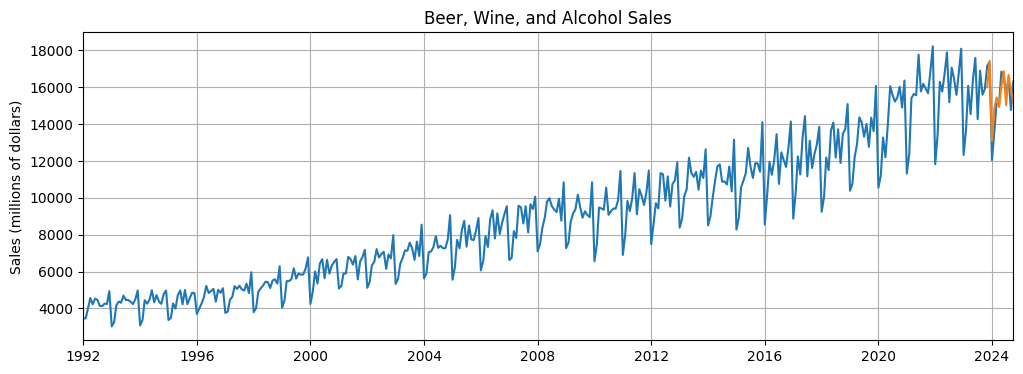

In [45]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

### Let's zoom in a little.

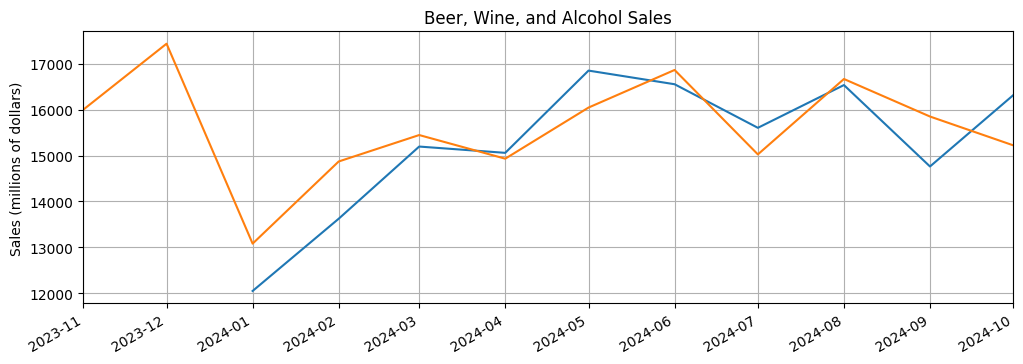

In [47]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2024-01-01':])
plt.plot(x,true_predictions)
plt.show()

For more information on x-axis date formatting in matplotlib, check out <a href='https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure.autofmt_xdate'><tt><strong>matplotlib.figure.Figure.autofmt_xdate</strong></tt></a> and <a href='https://matplotlib.org/api/dates_api.html#matplotlib.dates.DateFormatter'><tt><strong>matplotlib.dates.DateFormatter</strong></tt></a>

# Forecast into an unknown future
This time we'll continue training the model using the entire dataset, and predict 12 steps into the future.

In [48]:
epochs = 100

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00838176
Epoch:  2 Loss: 0.01491541
Epoch:  3 Loss: 0.02015723
Epoch:  4 Loss: 0.01529779
Epoch:  5 Loss: 0.02425063
Epoch:  6 Loss: 0.00976436
Epoch:  7 Loss: 0.01580166
Epoch:  8 Loss: 0.01254887
Epoch:  9 Loss: 0.00761302
Epoch: 10 Loss: 0.00667433
Epoch: 11 Loss: 0.00466848
Epoch: 12 Loss: 0.00880111
Epoch: 13 Loss: 0.00506417
Epoch: 14 Loss: 0.00823497
Epoch: 15 Loss: 0.00676379
Epoch: 16 Loss: 0.00675739
Epoch: 17 Loss: 0.00185928
Epoch: 18 Loss: 0.00837196
Epoch: 19 Loss: 0.00609302
Epoch: 20 Loss: 0.00021592
Epoch: 21 Loss: 0.00349386
Epoch: 22 Loss: 0.00206059
Epoch: 23 Loss: 0.00166086
Epoch: 24 Loss: 0.00101219
Epoch: 25 Loss: 0.00269651
Epoch: 26 Loss: 0.00263170
Epoch: 27 Loss: 0.00934337
Epoch: 28 Loss: 0.00155771
Epoch: 29 Loss: 0.00233074
Epoch: 30 Loss: 0.00275879
Epoch: 31 Loss: 0.00251680
Epoch: 32 Loss: 0.00046261
Epoch: 33 Loss: 0.01059932
Epoch: 34 Loss: 0.00423354
Epoch: 35 Loss: 0.00572441
Epoch: 36 Loss: 0.00113129
Epoch: 37 Loss: 0.00113989
E

## Predict future values, plot the result

In [49]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())


In [50]:
# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
true_predictions

array([[17173.00011888],
       [17356.00010073],
       [12050.0000221 ],
       [13623.00003308],
       [15195.00019631],
       [15058.00000209],
       [16849.00009906],
       [16551.99981681],
       [15603.00010389],
       [16533.99984086],
       [14761.00017256],
       [16314.99990711],
       [17113.26957166],
       [17269.91042477],
       [12372.21052495],
       [14028.95497245],
       [16043.6918866 ],
       [15103.77750072],
       [16884.09912407],
       [17732.65635443],
       [15828.35225129],
       [16840.62781718],
       [14717.67917106],
       [16207.47948939]])

## PLOT THE RESULT
**Set a data range for the predicted data.**
**Remember that the stop date has to be later than the last predicted value.**

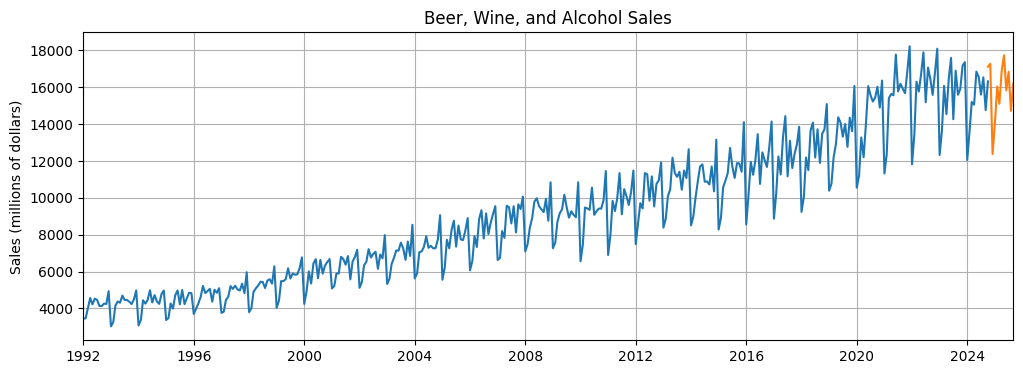

In [51]:
x = np.arange('2024-10-01', '2025-10-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

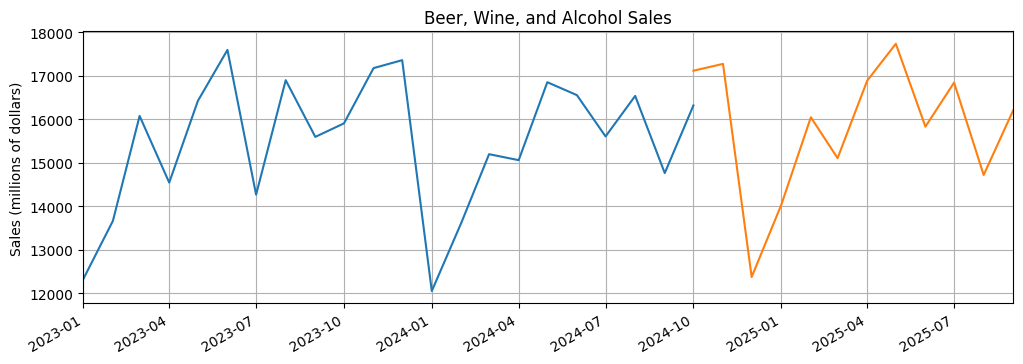

In [52]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2023-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()

### To save time in the future, we've written a function that will take in a time series training data set, and output a tensor of <tt>(seq, label)</tt> tuples.

In [53]:
# Load dependencies
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler
"""
This has to be done outside the function definition so that
we can inverse_transform the prediction set later on.
"""
scaler = MinMaxScaler(feature_range=(-1, 1))

# Extract values from the source .csv file
df = pd.read_csv('S4248SM144NCEN.csv',index_col=0,parse_dates=True)
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create the training set of values
train_set = y[:-test_size]

In [54]:
# DEFINE A FUNCTION:
def create_train_data(seq,ws=12):
    """Takes in a training sequence and window size (ws) of
       default size 12, returns a tensor of (seq/label) tuples"""
    seq_norm = scaler.fit_transform(seq.reshape(-1, 1))    
    seq_norm = torch.FloatTensor(seq_norm).view(-1)

    out = []
    L = len(seq_norm)
    for i in range(L-ws):
        window = seq_norm[i:i+ws]
        label = seq_norm[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [55]:
# Apply the function to train_set
train_data = create_train_data(train_set,12)
len(train_data)

370

In [56]:
train_data[0]

(tensor([-0.9437, -0.9438, -0.8722, -0.7982, -0.8433, -0.8028, -0.8111, -0.8544,
         -0.8558, -0.8383, -0.8408, -0.7492]),
 tensor([-1.]))

In [57]:
help(create_train_data)

Help on function create_train_data in module __main__:

create_train_data(seq, ws=12)
    Takes in a training sequence and window size (ws) of
    default size 12, returns a tensor of (seq/label) tuples

